- Install  library 'pyECLAT' that contains the implementation of the Eclat algorithm

In [1]:
#pip install pyECLAT

In [2]:
import pandas as pd              
import matplotlib.pyplot as plt
from pyECLAT import ECLAT        # For Eclat algorithm
import warnings
warnings.filterwarnings('ignore')

- We are using the dataset from library arules in R. Libray rpy2 provides an interface to R programming

In [3]:
#pip install rpy2

In [4]:
# enables the %%R magic
%load_ext rpy2.ipython

- We can run the R code in the cell below

In [5]:
%%R

library(arules)
data(Groceries) # Groceries object in arules
write(Groceries, file = "Groceries.csv", format="basket", sep = ",") # saving as a csv file

R[write to console]: Loading required package: Matrix

R[write to console]: 
Attaching package: 'arules'


R[write to console]: The following objects are masked from 'package:base':

    abbreviate, write




In [6]:
df = pd.read_csv('./Groceries.csv', names= list(range(0,32)))

df.head()

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,citrus fruit,semi-finished bread,margarine,ready soups,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,tropical fruit,yogurt,coffee,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,whole milk,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,pip fruit,yogurt,cream cheese,meat spreads,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,other vegetables,whole milk,condensed milk,long life bakery product,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


- Apply Eclat

In [7]:
eclat_instance = ECLAT(data=df, verbose=True)

_, supports = eclat_instance.fit(
    min_support=0.03,
    min_combination=2,
    max_combination=2,
    separator=' & ',
    verbose=True)

100%|██████████| 169/169 [00:00<00:00, 706.48it/s]


Combination 2 by 2


946it [00:25, 37.32it/s]


In [8]:
supports

{'sausage & rolls/buns': 0.030604982206405694,
 'soda & rolls/buns': 0.03833248601931876,
 'soda & other vegetables': 0.032740213523131674,
 'soda & whole milk': 0.040061006609049314,
 'pastry & whole milk': 0.033248601931875954,
 'root vegetables & other vegetables': 0.047381799694966954,
 'root vegetables & whole milk': 0.048906964921199794,
 'rolls/buns & yogurt': 0.03436705643111337,
 'rolls/buns & other vegetables': 0.042602948652770714,
 'rolls/buns & whole milk': 0.05663446873411286,
 'bottled water & whole milk': 0.03436705643111337,
 'tropical fruit & other vegetables': 0.035892221657346214,
 'tropical fruit & whole milk': 0.04229791560752415,
 'citrus fruit & whole milk': 0.030503304524656837,
 'whipped/sour cream & whole milk': 0.032231825114387394,
 'yogurt & other vegetables': 0.04341637010676157,
 'yogurt & whole milk': 0.05602440264361973,
 'other vegetables & whole milk': 0.07483477376715811,
 'pip fruit & whole milk': 0.030096593797661414}

- Convert rules to readable format

In [9]:
rows = []

for rule, support in supports.items():
    from_, to = rule.split(' & ')
    rows.append({
        'From': from_,
        'To': to,
        'Support': support
    })
    
rules_df = pd.DataFrame(rows)

rules_df.head()

,From,To,Support
0,sausage,rolls/buns,0.030605
1,soda,rolls/buns,0.038332
2,soda,other vegetables,0.032740
3,soda,whole milk,0.040061
4,pastry,whole milk,0.033249


- List rules with decreasing support

In [10]:
# List of all items
items = set(rules_df['From']) | set(rules_df['To'])

# Create a mapping of items to numbers
imap = {item : i for i, item in enumerate(items)}

# Map the items to numbers and add the numeric 'FromN' and 'ToN' columns
rules_df['FromN'] = rules_df['From'].map(imap)
rules_df['ToN'] = rules_df['To'].map(imap)

# Display the top 20 association rules, sorted by Support
rules_df.head(20).sort_values(by='Support', ascending=False)

,From,To,Support,FromN,ToN
17,other vegetables,whole milk,0.074835,9,6
9,rolls/buns,whole milk,0.056634,1,6
16,yogurt,whole milk,0.056024,5,6
6,root vegetables,whole milk,0.048907,4,6
5,root vegetables,other vegetables,0.047382,4,9
15,yogurt,other vegetables,0.043416,5,9
8,rolls/buns,other vegetables,0.042603,1,9
12,tropical fruit,whole milk,0.042298,8,6
3,soda,whole milk,0.040061,12,6
1,soda,rolls/buns,0.038332,12,1


- Plot each pair of items in the rule. Rule is A->B means item A is in the bottom row of the plot (y=0) and B is in the top row (y=1). The color of each line indicates the support of the rule multiplied by 100 (support*100). The width of each line is controlled by the confidence of each rule.

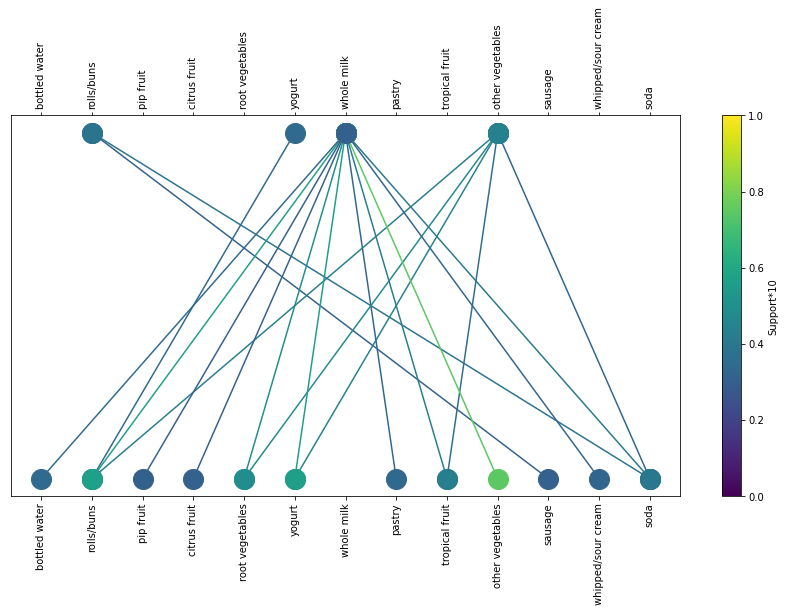

In [11]:
# Add ticks to the top of the graph also
plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = True

# Set the size of the plot
fig = plt.figure(figsize=(15, 7))

# Draw a line between items for each rule
# Colors each line according to the support of the rule
for index, row in rules_df.iterrows():
    plt.plot([row['FromN'], row['ToN']], [0, 1], 'o-',
             c=plt.cm.viridis(row['Support'] * 10),
             markersize=20)

# Add a colorbar and its title  
cb = plt.colorbar(plt.cm.ScalarMappable(cmap='viridis'))
cb.set_label('Support*10')

# Add labels to xticks and removes yticks
plt.xticks(range(len(items)), items, rotation='vertical')
plt.yticks([])
plt.show()